# Section IV. DYNAMICS AND CONTROL
    
# Chapter 17. Optimal Control

In previous chapters we have seen the use of myopic controllers like PID
or operational space control, as well as some predictive controllers
like trajectory generation. Particularly for complex and nonlinear
systems like robots, predictive control allows the controller to make
better decisions at the current time to account for future
possibilities. However, our previous predictive methods were largely
restricted to one class of systems. Optimal control addresses these
shortcomings in a highly general framework.

Optimal control asks to compute a control function (either open loop or
closed loop) that optimizes some performance metric regarding the
control and the predicted state. For example, a driver of a car would
like to reach a desired location while achieving several other goals:
e.g., avoiding obstacles, not driving erratically, maintaining a
comfortable level of accelerations for human passengers. A driving style
can be composed of some balanced combination of these goals. Optimal
control allows a control designer to specify the *dynamic model* and the
*desired outcomes*, and the algorithm will compute an optimized control.
This relieves some burden by letting the designer reason at the level of
*what* the robot should do, rather than designing *how* it should do it.

In this chapter, we will discuss how to specify optimal control problems
and how to implement and use optimal control techniques. We begin by discussing
the open loop problem, and then we will describe how an open
loop optimizer can be adapted to closed loop control via the use of
*model predictive control*.

Optimal control problem
-----------------------

An optimal control problem is defined by the dynamics function $f$ and a
*cost functional* over the entire trajectory $x$ and $u$:
$$J(x,u) = \int_0^\infty L(x(t),u(t),t) dt.$$ The term *functional*
indicates that this is a function mapping a function to a real number.
The term $L(x,u,t)$ is known as the *instantaneous cost* (or *running cost*) which is
accumulated over time, and should be chosen to be nonnegative and to
penalize certain undesirable states, velocities, or controls. Its units
are cost units per second.

The goal of optimal control is to find state and control trajectories
$x$ and $u$ such that $J(x,u)$ is minimized: $$\begin{gathered}
x^\star, u^\star = \arg \min_{x,u} J(x,u) \text{ such that} \\
\dot{x}(t) = f(x(t),u(t)) \text{ for all }t
\end{gathered}
\label{eq:OptimalControl}$$

TODO: illustration (Figure 1)

(For somewhat technical reasons, there are problems for which no optimal
trajectory exists, but rather only a sequence of trajectories
approaching an optimal cost. Hence, if we prefer to be pedantic, it is
often necessary to prove existence of an optimal solution first, or to
relax the problem to determine only an approximate optimum.)

### Cost functionals

A variety of behaviors can be specified in this framework by modifying
the instantaneous cost. For example:

- Trajectory tracking for a trajectory $x_D(t)$ can be implemented by penalizing squared error $L(x,u,t) = \|x - x_D(t)\|^2$.
- Minimizing effort can be defined in terms of a control penalty $\|u\|^2$.
- Minimum time to hit a target $x_{tgt}$ could be implemented as an indicator function $I[x\neq x_{tgt}]$ where $I[z]$ is 1 if $z$ is true, and 0 otherwise.
- Obstacle avoidance and other feasibility constraints can be implemented as indicator functions as well, $\infty \cdot I[x \notin \mathcal{F}]$ where $\mathcal{F}$ is the free space.
- Smoothed obstacle avoidance can be implemented by a repulsive barrier that decreases to 0 when the distance to the closest obstacle $d$ exceeds some minimum buffer distance $d_{min}$ and incrases to infinity as the distance shrinks to 0. One common form of this barrier is $L(x,u,t) = 1/d^2 - 1/d_{min}^2$ when $d < d_{min}$ and $L(x,u,t) = 0$ otherwise.

TODO: illustration (Figure 2)

It is common to mix and match different types of costs functionals using a _weighted cost functional_ $$J(x,u) = \sum_{i=1}^N w_i J_i(x,u)$$
where each $J_i(x,u)$ is some primitive cost functional and $w_i$ scales its contribution to the final cost. By tuning these weights, a designer can encourage the optimized trajectories to emphasize some aspects of the trajectory over others.


### Finite horizon optimal control and discounting

As stated, this problem is somewhat ill-behaved because it
involves an infinite integral, which could achieve infinite cost even
for relatively well-behaved trajectories. For example, if the cost were
simply squared error, a trajectory that achieves 0.01 steady-state error
would be rated as having the same cost as a trajectory that had an error
of 1: namely, infinitely bad.

There are two general ways to make the cost functional better behaved.
The first method to truncate the problem at some maximum time $T$,
leading to a *finite-horizon optimal control* cost functional
$$J(x,u) = \int_0^T L(x(t),u(t),t) dt + \Phi(x(T))$$ where $\Phi(x)$ is
a nonnegative *terminal cost* that penalizes the state attained at the
terminal time.

The second method is to modify the instantaneous cost functional by
including a *discount factor* that decays to 0 relatively quickly as
$t \rightarrow \infty$. This is usually expressed as the product of a
time-independent term and a time-dependent discount factor term:
$$L(x,u,t) = L(x,u,0) \gamma(t)$$ with $\gamma(t)$ a decaying function,
such as $O(1/t^\alpha)$ or $O(\beta^t)$. It is important to choose a
discount factor that drops relatively rapidly toward 0 to ensure that
the cost is integrable. Discount factors of the form $O(1/t^\alpha)$
must have $\alpha > 1$ to ensure that the cost functional is finite for
all bounded trajectories, and those of the form $O(\beta^t)$ must have
$\beta < 1$.

### State and Control Constraints

Usually, optimal control solvers require that the cost functional is
smooth, and so non-differentiable constraints like minimum time and
obstacle avoidance must be reformulated as hard constraints, external to
the cost functional. As a result the reformulation becomes essentially
an infinite-dimensional constrained optimization problem. Solvers may
differ about whether they can handle constraints on state or constraints
on control.

### Analytical vs Numerical Solvers

Minimization over a space of functions is considerably more difficult to
solve than typical optimization problems: the space of functions is
*uncountably infinite-dimensional*! There are two general ways to tackle
these problems: analytical or numerical. Analytical techniques use the
mathematical conditions of optimality so that the optimal control can be
determined directly through calculus and algebraic manipulation.
Successfully applying analysis typically requires a relatively simple
dynamics and cost. Numerical techniques approximate the problem by
discretizing either the state, time, and/or control space and attempt to cast
the problem as a finite dimensional optimization. These are more
general-purpose and can be applied to complex problems, but are more
computationally expensive and usually require some parameter tuning to
obtain high-quality solutions.


LQR control
-----------

The simplest class of optimal control problems is LTI systems with costs
that are quadratic in $x$ and $u$. Through the calculus of variations,
which is beyond the scope of this book, the optimal control for this
problem class can be determined analytically as a closed-form function
of $x$.

LTI systems with quadratic cost are specified as $\dot{x} = Ax + Bu$ and
$$L(x,u,t) = x^T Q x + u^T R u$$ where $Q$ and $R$ are symmetric
matrices of size $n\times n$ and $m\times m$, respectively. The
magnitude of entries of $Q$ penalize error from the equilibrium point,
and the magnitude of entries of $R$ penalize control effort. The overall
control functional is therefore
$$J(x,u) = \int_0^\infty x(t)^T Q x(t) + u(t)^T R u(t).$$

Here, the optimal control can be shown to be a linear function of $x$:
$$u = -Kx$$ for the gain $K = R^{-1}B^T P$ defined as a function of an
unknown matrix $P$. $P$ is a symmetric $n \times n$ matrix that solves
the following *Riccati equation* :
$$A^TP + PA -  PBR^{-1}B^TP + Q = 0.$$ Numerical methods are available
for solving the Riccati equation for $P$. This method is known as the
Linear Quadratic Regulator (LQR) approach.

TODO: illustration (Figure 3)

As we showed in the [section on LTI stability](Control.ipynb#Stability-in-Linear-Time-Invariant-Systems),
traditional pole placement methods can be
used to derive a stable controller for LTI systems. However, the
significance of the LQR controller compared to traditional pole
stability analysis is that the performance metric is made explicit
rather than implicit. Moreover, it gives a closed form solution for any
dynamic model specified by $A,B$, so if more information is gathered
that yields a better estimate for $A$ and $B$, the LQR method can be
applied directly to obtain the optimal gains.


Pointryagin's Minimum Principle
-------------------------------

The "magic" of the LQR solution is obtained through a more generic
principle of optimal controllers called the *Pointryagin's minimum
principle*. It defines a *first order*, *necessary* condition for a
particular state/control trajectory to be an optimum. It is derived from
($\ref{eq:OptimalControl}$) via a combination of calculus of
variations and the method of Lagrange multipliers. This will briefly be
described here.

In (equality) constrained optimization problems, the method of Lagrange
multipliers defines an auxiliary Lagrange multiplier variable
$\lambda_i$ for each equality constraint. However, in optimal control
problems, there are an infinite number of equality constraints
$\dot{x}(t) = f(x(t),u(t))$ defined for each point in time. As a result,
the Lagrange multipliers for this problem are not single variables, but
rather *trajectories* defined over time. This trajectory of multipliers
is known as a *costate trajectory*
$\lambda(t):[0,\infty)\rightarrow \mathbb{R}^n$.

An auxiliary function, called the *Hamiltonian*, is defined over the
system and costate at particular points in time:
$$H(\lambda,x,u,t)=\lambda^T f(x,u) + L(x,u,t).$$ It is also possible to
maintain control constraints $u\in \mathcal{U}\subseteq \mathbb{R}^m$.

Pointryagin's minimum principle is then stated as follows. An optimal
state/ control/ costate trajectory $(x^\star,u^\star,\lambda^\star)$
satisfies for all $t \geq 0$:

1.  $H(\lambda^\star(t),x^\star(t),u^\star(t),t) \leq H(\lambda^\star(t),x^\star(t),u,t)$
    for all $u \in \mathcal{U}$

2.  $\dot{x}^\star(t) = f(x^\star(t),u^\star(t))$

3.  $\dot{\lambda}^\star(t) = -\frac{\partial}{\partial x}H(\lambda^\star(t),x^\star(t),u^\star(t),t)$.

The derivation of these equations is outside the scope of this book. But
the conditions can be applied in certain cases to obtain optimal
controls, or at least limit the range of controls possibly optimal.

### Derivation of LQR from PMP

As a result, consider the LQR setting. The Hamiltonian is
$$H(\lambda,x,u,t) = \lambda^T(Ax + Bu) + x^T Q x + u^T R u$$ and the
Pointryagin's minimum principle gives:

1.  Subtracting off terms that do not contain $u$,
    $\lambda^{\star T}Bu^{\star} + u^{\star T} R u^\star \leq \lambda^{\star T}Bu + u^T R u$
    for all $u$.

2.  $\dot{x}^\star = Ax^\star + Bu^\star$

3.  $\dot{\lambda}^\star = - A^T \lambda^{\star}  - 2 Qx$.

Expanding 1, we see that for $u^\star$ to be a minimizer of the
Hamiltonian, given $\lambda^\star$, $x^\star$, and $t$ fixed, we must
have that $B^T \lambda^\star + 2 R u^\star = 0$ so that
$u^\star = \frac{1}{2}R^{-1} B^T \lambda^\star$.

Now replacing this into 2 and 3, we have a system of ODEs:
$$\begin{split}
\dot{x}^\star &= A x^\star + \frac{1}{2} B R^{-1} B^T \lambda^\star \\
\dot{\lambda}^\star &= - 2 Qx^\star  -A^T \lambda^\star
\end{split}$$ 

Hypothesizing that $\lambda^\star = 2 P x^\star$ and
multiplying the first equation by $P$, we obtain the system of equations

$$\begin{split}
P\dot{x}^\star &=  (PA + P B R^{-1} B^T P )x^\star \\
2P\dot{x}^\star &= (-2Q  -2A^T P)x^\star.
\end{split}$$ 

After dividing the second equation by 2 and equating the
left hand sides, we have an equation that must be satisfied for all $x$.
Since the equation must hold for all $x$, the matrices must also be
equal, which produces the Riccati equations.

### Bang-bang control

Another result from Pointryagin's minimum principle condition (1) is
that the Hamiltonian must be minimized by the control, keeping the state
and costate fixed. As a result, there are two possibilities: (1a) the
derivative of the Hamiltonian is 0 at $u^\star$, or (1b) the control is
at the boundary of the control set $u^\star \in \partial U$.

This leads to many systems having the characteristic of *bang-bang
control*, which means that the optimal control will jump discontinuously
between extremes of the control set. As an example, consider a race car
driver attempting to minimize time. The optimal control at all points in
time will either maximize acceleration, maximize braking, or
maximize/minimize angular acceleration; otherwise, time could be saved
by making the control more extreme.

TODO: illustration (Figure 4)

If it can be determined that there are a finite number of possible
controls satisfying condition (1), then the optimal control problem
becomes one of simply finding *switching times* between optimal
controls.

Taking the [Dubins car model](WhatAreDynamicsAndControl.ipynb#Dubins-car) as an example, 
we have the state variable
$(x,y,\theta)\in SO(2)$ and control variable $(v,\phi)$ denoting
velocity and steering angle: $$\begin{split}
\dot{x} &= v \cos \theta \\
\dot{y} &= v \sin \theta \\
\dot{\theta} &= v/L \tan \phi .
\end{split}$$ 

Here $(x,y)$ are the coordinates of a point in the middle
of the rear axis, and $L$ is the length between the rear and front axle.
The velocity and steering angle are bounded, $v \in [-1,1]$ and
$\phi \in [-\phi_{min},\phi_{max}]$, and the cost only measures time to
reach a target state. Hence, the Hamiltonian is
$$H(\lambda,x,u,t) = \lambda_1 v \cos \theta + \lambda_2 v \sin \theta + \lambda_3 v/L \tan \phi + I[x \neq x_{tgt}]$$

The latter term does not contribute to the choice of $u$, so we can
ignore it. For $(v,\phi)$ to be a minimum of the Hamiltonian, with
$\lambda$ and $x$ fixed, either $\lambda = 0$ and the control is
irrelevant, or $\lambda \neq 0$ and
$v = -sign(\lambda_1 \cos \theta + \lambda_2 \sin \theta + \lambda_3 /L \tan \phi)$.
Then, since $\tan$ is a monotonic function, we have
$\phi = -sign(\lambda_3 v)\phi_{max}$. As a result, the only options are
the minimum, maximum, and 0 controls on each axis.

The trajectories corresponding to these extrema are straight
forward/backward, moving forward while turning left/right, and moving
backward while turning left/right. The curves traced out by these
trajectories are then either straight line segments or arcs of turning
rate $\pm \tan \phi_{max}/L$. To find all minimum-time paths between two
points, it is then a matter of enumerating all possible arcs and
straight line segments. The solutions are known as Reeds-Shepp curves.

Trajectory Optimization
-----------------------

It is not always possible (or easy) to derive elegant expressions of
optimal controls using Pointryagin's minimum principle for general
nonlinear systems. For example, if any modification is made to an LQR
system, such as a non-quadratic term in the cost functional, or if state
constraints or control constraints are added, the analytical solution no
longer applies. As a result, numerical methods can solve a wider variety
of optimal control problems. We have already seen
a form of trajectory optimization under the discussion of kinematic path
planning, and here we extend this type of formulation to dynamic systems.

Since trajectories are infinite-dimensional, the main challenge of
trajectory optimization is to suitably discretize the space of
trajectories. A second challenge is that the discretized optimization
problem is usually also fairly large, depending on the granularity of
the discretization, and hence optimization may be computationally
inefficient.

In any case, the general method for performing trajectory optimization
follows the following procedure 1) define a set of basis functions for the control
trajectory, 2) defining a state evolution technique, 3) reformulating
($\ref{eq:OptimalControl}$) as a finite-dimensional optimization
problem over the coefficients of the basis functions, and 4) optimizing
using a gradient-based technique.

### Direct transcription

The main choice in trajectory optimization is how to represent a
trajectory of controls? The most typical assumption is that the
trajectory consists of piecewise-constant controls at a fixed time step.

If we define the time step $\Delta t = T/N$ with $N$ an integer, then we
have the *computational grid*
$0, \Delta t, 2\Delta t, \ldots, N\Delta t$. Let these grid points be
denoted $t_0,t_1,\ldots,t_N$ respectively with $t_0=0$ and $t_N=T$.

Then, the entire control trajectory is specified by a control sequence
$u_1,\ldots,u_N$, with each $u_i$ active on the time range
$[t_{i-1},t_i)$. In other words $u(t) = u_i$ with
$i = \lfloor t/\Delta t \rfloor + 1$.

Suppose now we define a *simulation function*, which is a method for
integrating the state trajectory over time. Specifically, given an
initial state $x(0)$, a constant control $u$, and a fixed duration $h$,
the simulation function $g$ computes an approximation
$$x(h) \approx g(x(0),u,h)$$ If the timestep is small enough, the Euler
approximation is a reasonable simulation function:
$$x(h) \approx x(0) +h f(x(0),u).$$ If accuracy of this method is too
low, then Euler integration could be performed at a finer time sub-step
up to time $h$, and/or a more accurate integration technique could be
used.

TODO: illustration (Figure 5)

In any case, given a piecewise-constant control trajectory defined by a
control sequence $u_1,\ldots,u_N$, we can derive corresponding points on
the state trajectory as follows.

1.  Set $x_0 \gets x(0)$.

2.  For $i=1,\ldots,N$, set $x_i = g(x_{i-1},u_i,\Delta t)$ to arrive at a state sequence $x_0=x(0),x_1,\ldots,x_N$. 

With this definition, each $x_i$ is a function of $u_1,\ldots,u_i$. Hence, we can
approximate the cost functional as:
$$J(x,u) \approx \tilde{J}(u_1,\ldots,u_n) = \delta t \sum_{i=0}^{N-1} L(x_i,u_{i+1},t_i)  + \Phi(x_N).$$
Using this definition we can express the approximated optimal control
function as a minimization problem:
$$\arg \min_{u_1,\ldots,u_N} \tilde{J}(u_1,\ldots,u_N).
\label{eq:DirectTranscription}$$
With control space $\mathbb{R}^m$, this is an
optimization problem over $mN$ variables.  This formulation is also known
as _direct transcription_.

There is a tradeoff in determining the resolution $N$. With higher
values of $N$, the control trajectory can obtain lower costs, but the
optimization problem will have more variables, and hence become more
computationally complex. Moreover, it will be more susceptible to local
minimum problems.

### Descent approaches

Standard gradient-based techniques can be used to solve the direct transcription problem
($\ref{eq:DirectTranscription}$). One difficulty is that to take the gradient
of $\tilde{J}$ with respect to a control variable $u_i$, observe that
this choice of control affects *every* state variable $x_k$ with
$i \leq k \leq N$. Hence,
$$\frac{\partial J}{\partial u_i} = \Delta t \frac{\partial L}{\partial u_i} (x_{i-1},u_i,t_i) + \Delta t \sum_{k=i}^{N-1} \frac{\partial L}{\partial x}(x_k,u_{k+1},t_k)\frac{\partial x_k}{\partial u_i} + \frac{\partial \Phi}{\partial x_N}\frac{\partial x_N}{\partial u_i}
\label{eq:JacobianUi}$$ The expressions for
$\frac{\partial x_k}{\partial u_i}$ are relatively complex because $x_k$
is defined recursively assuming that $x_{i-1}$ is known. $$\begin{split}
x_i &= g(x_{i-1},u_i,\Delta t) \\
x_{i+1} &= g(x_i,u_{i+1},\Delta t) \\
x_{i+2} &= g(x_{i+1},u_{i+2},\Delta t) \\
&\vdots
\end{split}$$
In this list, the only equation directly affected by $u_i$
is the first. The effects on the remaining states are due to cascading
effects of previous states. Hence, we see that
$$\frac{\partial x_i}{\partial u_i} = \frac{\partial g}{\partial u}(x_{i-1},u_i,\Delta t)$$
$$\frac{\partial x_{i+1}}{\partial u_i} = \frac{\partial x_{i+1}}{\partial x_i}  \frac{\partial x_i}{\partial u_i} = \frac{\partial g}{\partial x}(x_i,u_{i+1},\Delta t) \frac{\partial x_i}{\partial u_i}$$
And in general, for $k > i$,
$$\frac{\partial x_k}{\partial u_i} = \frac{\partial g}{\partial x}(x_{k-1},u_k,\Delta t) \frac{\partial x_{k-1}}{\partial u_i}.$$
This appears to be extremely computationally expensive, since each
evaluation of ($\ref{eq:JacobianUi}$) requires calculating $O(N)$ derivatives,
leading to an overall $O(N^2)$ algorithm for calculating the gradient
with respect to the entire control sequence.

However, with a clever forward/backward formulation, the gradient can be calculated with $O(N)$ operations.
Note that all expressions of the form
$\frac{\partial x_k}{\partial u_i}$ are equivalent to
$\frac{\partial x_k}{\partial x_i}\frac{\partial x_i}{\partial u_i}$.
So, we observe that
($\ref{eq:JacobianUi}$) is equal to
$$\Delta t \frac{\partial L}{\partial u_i}(x_{i-1},u_i,t) + \frac{\partial J}{\partial x_i} \frac{\partial x_i}{\partial u_i}.$$
Then, we can express:
$$\frac{\partial J}{\partial x_i} = \Delta t \sum_{k=i}^{N-1} \frac{\partial L}{\partial x}(x_k,u_{k+1},t_k) \frac{\partial x_k}{\partial x_i} + \frac{\partial \Phi }{\partial x_N}\frac{\partial x_N}{\partial x_i}.$$
This entire vector can be computed in a single backward pass starting
from $i=N$ back to $i=1$. Starting with $i=N$, see that
$$\frac{\partial J}{\partial x_N} = \frac{\partial \Phi }{\partial x_N}$$
Then, proceeding to $i=N-1$, observe $$\begin{split}
\frac{\partial J}{\partial x_{N-1}} &= \Delta t \frac{\partial L}{\partial x}(x_{N-1},u_N,t_{N-1}) + \frac{\partial \Phi }{\partial x_N}\frac{\partial x_N}{\partial x_{N-1}} \\
&=  \Delta t \frac{\partial L}{\partial x}(x_{N-1},u_N,t_{N-1}) + \frac{\partial J}{\partial x_N} \frac{\partial x_N}{\partial x_{N-1}}.
\end{split}$$ In general, with $i<N$, we have the recursive expression
$$\frac{\partial J}{\partial x_i} =  \Delta t \frac{\partial L}{\partial x}(x_i,u_{i+1},t_i) + \frac{\partial J}{\partial x_{i+1}} \frac{\partial x_{i+1}}{\partial x_{i}}.$$
The entire set of values can be computed in $O(N)$ time for all
$x_1,\ldots,x_N$.

However, problems of this sort are usually poorly scaled, and hence
standard gradient descent converges slowly. The most commonly used
higher-order technique is known as _Differential Dynamic Programming_
(DDP), which is an efficient recursive method for performing Newton's
method. Given a current control trajectory, it approximates the cost
function as a quadratic function of the controls, and solves for the
minimum of the function.  A similar approach is the _Iterative LQR_ (iLQR) algorithm, which is very closely related to DDP but drops the 2nd derivative of the dynamics function. The exact steps for implementing DDP and iLQR are beyond
the scope of this course but are readily available from other sources.  TODO: add links.

TODO: illustration (Figure 6)

### Pseudospectral / collocation methods

As an alternative to piecewise constant controls, it is also possible to
use other discretizations, such as polynomials or splines. In any case,
the control is specified by a linear combination of *basis functions*
$$u(t) = \sum_{i=1}^k c_i \beta_i(t)$$ where the $c_i \in \mathbb{R}^m$
are control coefficients, which are to be chosen by the optimization,
and the basis functions $\beta_i(t)$ are constant. For example, a set of
polynomial basis functions could be $1$, $t$, $t^2$, \..., $t^{k-1}$.
The difficulty with such parameterizations is that the state trajectory
depends on every control coefficient, so evaluating the gradient is
computationally expensive. 

To address this problem, it is typical to include a *state trajectory parameterization* in
which the state trajectory $x(t)$ is also represented as an optimization variable that is
parameterized explicitly along with the control trajectory. Specifically, we suppose that $$x(t) = \sum_{i=1}^k d_i \gamma_i(t)$$ where the $d_i \in \mathbb{R}^n$ are state coefficients to be optimized, and the basis functions $\gamma_i$ are constant functions of time.

TODO: illustration (Figure 6)

The main challenge is then to enforce dynamic consistency between the $x$ trajectory and the $u$ trajectory over the time domain.  Because it is impossible to do this exactly in a continuous infinity of points, the dynamic consistance must then be enforced at a finite number of points
in time, which are known as *collocation points*. The result is an
equality-constrained, finite-dimensional optimization problem.

Specifically, given $N$ points in the time domain $t_1,\ldots,t_N$, dynamic consistency is enforced at the $j$'th time point with a constraint
$$
x^\prime(t_j) = f(x(t_j),u(t_j) )
$$
which can be rewritten in terms of the cofficients
$$
\sum_{i=1}^k d_i \gamma_i^\prime(t_j) = f\left(\sum_{i=1}^k d_i \gamma_i(t_j), \sum_{i=1}^k c_i \beta_i(t_j) \right).
$$

TODO: describe the ultimate optimization formulation.


### Handling infinite-horizon problems

There are some challenges when applying trajectory optimization to
infinite-horizon optimal control problems. Specifically, it is not
possible to define a computational grid over the infinite domain
$[0,\infty)$ for the purposes of computing the integral in $J(x,u)$. To
do so, there are two general techniques available. The first is to
simply truncate the problem at some maximum time $T$, leading to a
finite-horizon optimal control problem.

The second method is to reparameterize time so that the range
$[0,\infty)$ is transformed into a finite range, say $[0,1]$. If we let
$s=1-e^t$ then $s$ is in the range $[0,1]$. The cost functional then
becomes:
$$J(x,u) = \int_0^1 L(x(-\ln(1-s)),u(-\ln(1-s)),-\ln(1-s)) / (1-s) ds.$$
This leads to a finite-horizon optimal control problem over the $s$
domain, with $T=1$. Hence, if a uniform grid is defined over
$s \in [0,1]$, then the grid spacing in the time domain becomes
progressively large as $t$ increases.

In the reformulated problem it is necessary to express the derivative of
$x$ with respect to $s$ in the new dynamics:
$$\frac{d}{d s} x(t(s)) = \dot{x}(t(s)) t^\prime(s) = f(x(t(s)),u(t(s))) / (1-s)$$
Care must also be taken as $s$ approaches 1, since the $1/(1-s)$ term
approaches infinity, and if instantaneous cost does not also approach 0,
then cost will become infinite. It is therefore customary to use a
discount factor. With an appropriately defined discount term, the $s=1$
contribution to cost will be dropped.

### Local minima

A major issue with any descent-based trajectory optimization approach is
local minima. Only in a few cases can we prove that the problem is
convex, such as in LTI problems with convex costs and linear control
constraints.

As we have seen before, random restarts are one of the most
effective ways to handle local minima, but trajectory optimization takes place
in a very high dimensional space. Due to the high dimensionality of the parameter space,
a prohibitive number of restarts is needed if we want to have a high chance of finding a
global optimum.  Hence, for a robot to perform trajectory optimization reliably, a considerable amount of
effort needs to be spent finding good initializers or engineering the cost landscape
such that it has few local minima.

Hamilton-Jacobi-Bellman Equation
--------------------------------

An alternative method to solve optimal control problems is to find the
solution in *state space* rather than the time domain. In the
Hamilton-Jacobi-Bellman (HJB) equation, so named as an extension of the
Bellman equation for discrete optimal planning problems, a partial
differential equation (PDE) across state space is formulated to
determine the optimal control everywhere. (Contrast this with the
Pointryagin's minimum principle, which is an optimality condition only
along a single trajectory.)

### Derivation

We start by formulating the HJB equation in discrete time. Consider a
finite-horizon optimal control problem, and define the *value function*
as a function
$V(x,t) : \mathbb{R}^n \times \mathbb{R} \rightarrow \mathbb{R}$ that defines the
*minimum possible accumulated cost* that could be obtained by any trajectory
starting from initial state $x$ and time $t$.  In other words, let us define the
truncated cost functional
$$J_t(x,u) = \int_t^T L(x,u,s) ds + \Phi(x(T))$$
which truncates the lower point in the integral term of $J(x,u)$ to start from time
$t$. (Obviously, $J(x,u)=J_0(x,u)$.)  Then, the value function is the minimizer of
the truncated cost over all possible future controls: $V(x,t) = \min_u(J_t(x,u))$.
The value is also known as the *cost to come*, measuring the remaining cost to reach
a goal. (This stands in contrast to the *cost to go* which is the cost that would be
accumulated to reach a state $x$ from the start.)

TODO: illustration (Figure 7)

It is apparent that at time $T$, the only term that remains is the
terminal cost, so one boundary term is given: $$V(x,T) = \Phi(x).$$ Now
we examine the value function going backwards in time. Suppose we know
$V(x,t+\Delta t)$ for all $x$, and now we are considering time $t$. Let
us also assume that at a state $x$ with control $u$, the resulting state
at time $T$ is approximated by Euler integration, and the incremental
cost is approximately constant over the interval $[t,t+\Delta t)$. Then,
we have the approximation
$$V(x,t) \approx \min_{u\in U} [ \Delta t L(x,u,t) + V(x + \Delta t f(x,u),t+\Delta t)]
\label{eq:DiscreteTimeHJB}$$ The minimization is taken over controls to
find the optimal control for the next time step. The first term of the
minimized term includes the incremental cost from the current state,
time, and chosen control. The second term includes the cost contribution
from the next state under the chosen control, incremented forward in
time.

Note that the first order approximation of $V(x,t)$ is given by:
$$V(x+\Delta x,t+\Delta t) \approx V(x,t) + \frac{\partial V}{\partial x}(x,t) \Delta x + \dot{V}(x,t)\Delta t$$
If we take the limit of
($\ref{eq:DiscreteTimeHJB}$) as the time step $\Delta t$ approaches
0, subtract $V(x,t)$ from both sides, and divide by $\Delta t$, then we
obtain the Hamilton-Jacobi-Bellman PDE :
$$0 = \dot{V}(x,t) + \min_{u \in U} [ L(x,u,t) + \frac{\partial V}{\partial x}(x,t) f(x,u)].
\label{eq:HJB}$$

If these equations were to be solved either in discrete or continuous
time across the $\mathbb{R}^n \times \mathbb{R}$ state space, then we
have a complete description of optimal cost starting from any state. It
is also possible to enforce state constraints simply by setting the
value function at inadmissible states to $\infty$. Moreover, it is a
relatively straightforward process to determine the optimal control
given a value function:
$$u^\star(x,t) = \arg \min_{u \in U} [ \Delta t L(x,u,t) + V(x + \Delta t f(x,u),t + \Delta t)]$$
for the discrete case and
$$u^\star(x,t) = \arg \min_{u \in U} [ L(x,u,t) + \frac{\partial V}{\partial x}(x,t) f(x,u)]$$
for the continuous case. The main challenge here is to represent and
calculate a function over an $n+1$ dimensional grid, which is
prohibitively expensive for high-D state spaces. It is also potentially
difficult to perform the minimization over the control
in ($\ref{eq:DiscreteTimeHJB}$)
and ($\ref{eq:HJB}$),
since it must be performed at each point in time and space.

### Reducing dimension by 1 using time-independence

It is often useful to reduce the dimensionality down to an $n$-D grid if
the incremental cost is time-independent and the problem has an infinite
horizon. With these assumptions, the optimal control is *stationary*,
that is, it is dependent only on state and not time. Then, we can set up
a set of recursive equations on a time-independent value function:

$$V(x) = \min_{u \in U} [ \Delta L(x,u) + V(x+\Delta t f(x,u)) ]
\label{eq:DiscreteHJBStationary}$$

in the discrete time case, or taking
the limit as $\Delta t \rightarrow 0$, we get the continuous PDE

$$0 = \min_{u \in U} [ L(x,u) + \frac{\partial V}{\partial x}(x) f(x,u) ].$$

### Solution methods

It can be rather challenging to solve either the time-dependent or the
stationary equations exactly due the dimensionality of the grids used,
and the recursive nature of the stationary equations. Also, some
discretization of the control set $U$ is usually needed, and a
finer discretization will help the method
compute better estimates. Three general methods exist for solving HJB
equations:

1.  Value iteration uses a guess of $V(x)$ and then iteratively improves
    it by optimizing
    ($\ref{eq:DiscreteHJBStationary}$) on each $x$ in the grid. This
    is also known as recursive dynamic programming and is a continuous-space variant of the
    value iteration algorithm discussed in [Chapter 11](PlanningWithDynamicsAndUncertainty.ipynb#Value-iteration).

2.  Policy iteration assigns guesses for the policy $u(x)$, and
    iteratively alternates between a) solving for the $V(x)$ induced by
    those controls, and b) improving the assigned controls using the
    induced $V(x)$.  This is a continuous-space  variant of the
    policy iteration algorithm discussed in [Chapter 11](PlanningWithDynamicsAndUncertainty.ipynb#Policy-iteration).

3.  Linear programming uses a set of sample points $x_1,\ldots,x_N$ on a
    state space grid and points $u_1,\ldots,u_M$ on a control space
    grid, and then sets up a large linear programming problem with
    constraints of the form
    ($\ref{eq:DiscreteHJBStationary}$).

4.  The Fast Marching Method can be thought of as a one-pass value iteration, which is
    applicable to problems with known terminal sets and positive costs.  The principle is similar to
    the "brush fire" method for calculating navigation functions as discussed in
    [Chapter 11](PlanningWithDynamicsAndUncertainty.ipynb#Navigation-functions-and-the-Dynamic-Window-Approach). 
    Observe that once a value is defined for the goal states, their value no
    longer needs to be updated; they are called *closed*.  We can try to
    determine all states for which the value is below some threshold $v$, and these
    states will be found in a small neighborhood of the closed states, known as the *frontier*.
    Once these states' values are determined, they are added to the closed states, and a new set of
    frontier states is determined.  Next, we increase $v$ and repeat the process, until all
    states are visited.


Start state [4.71238898 0.        ] goal state [1.57079633 0.        ]


#### HJB Solver

<IPython.core.display.Javascript object>


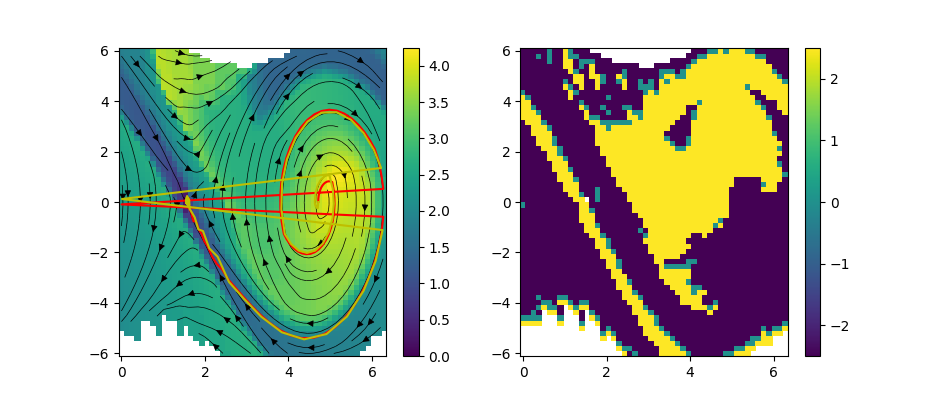

interactive(children=(IntSlider(value=11, description='i', max=101, min=1, step=10), Button(description='Run I…

In [4]:
#Code for a pendulum HJB problem
from rsbook_code.control.examples.pendulum import Pendulum
from rsbook_code.control.optimalcontrol import OptimalControlProblem,ControlSampler,rollout_policy,LookaheadPolicy
from rsbook_code.control.objective import ObjectiveFunction
from rsbook_code.control.hjb import HJBSolver,OptimalControlTreeSolver
from rsbook_code.control.dynamics import simulate
import numpy as np
import math

#this is needed to sample from the control space
class PendulumControlSampler(ControlSampler):
    def __init__(self,umin,umax):
        self.umin = umin
        self.umax = umax
    def sample(self,state):
        return [[self.umin],[0],[self.umax]]
    
class TimeObjectiveFunction(ObjectiveFunction):
    def __init__(self,dt):
        self.dt = dt
    def incremental(self,state,control):
        return abs(self.dt)
    
class EffortObjectiveFunction(ObjectiveFunction):
    def __init__(self,dt):
        self.dt = dt
    def incremental(self,state,control):
        return np.linalg.norm(control)**2*self.dt

#create the dynamics function, terminal conditions, and control bounds
dynamics = Pendulum()
umin = -2.5
umax = 2.5
down = np.array([math.pi*3/2,0])
right = np.array([0,0])
up = np.array([math.pi/2,0])
start = down
goal = up
bounds = [(0,math.pi*2),(-6,6)]
controlSampler = PendulumControlSampler(umin,umax)
#need to set dt large enough to have a chance to jump cells
dt = 0.1
objective = TimeObjectiveFunction(dt)
problem = OptimalControlProblem(start,dynamics,objective,goal=goal,controlSampler=controlSampler,dt=dt)

grid_resolution = (50,60)
hjb = HJBSolver(problem,bounds,grid_resolution)
scell = hjb.stateToCell(problem.x0)
print("Start state",start,"goal state",goal)
#print("Start cell",scell)
#print("Start cell center state",hjb.cellToCenterState(scell))
#print("Goal cell",hjb.stateToCell(problem.goal))

from rsbook_code.control.hjb import GridCostFunctionDisplay
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display,Markdown
import matplotlib.pyplot as plt
%matplotlib notebook

display(Markdown("#### HJB Solver"))
hjbdisplay = GridCostFunctionDisplay(hjb,hjb.value,hjb.policy,policyDims=1,figsize=(9.5,4))
hjbdisplay.show()

def do_value_iteration(i):
    print("Running",i,"value iteration steps")
    hjb.valueIteration(iters=i)
    hjbdisplay.refresh(hjb.value,hjb.policy)
    if hjb.getPolicy(start) is not None:
        #show the HJB policy 
        xs,us = rollout_policy(dynamics,start,(lambda x:hjb.getPolicy(x)),dt*0.5,200)
        hjbdisplay.plotTrajectory(xs,color='r',zorder=3)
        
        la_policy = LookaheadPolicy(problem,hjb.interpolateValue,goal=(lambda x:False))
        xs,us = rollout_policy(dynamics,start,la_policy,dt,200)
        hjbdisplay.plotTrajectory(xs,color='y',zorder=4)
    hjbdisplay.plotFlow(lambda x:hjb.getPolicy(x),color='k',linewidth=0.5)
interact_manual(do_value_iteration,i=widgets.IntSlider(min=1, max=101, step=10, value=11));


# Forward Solver

<IPython.core.display.Javascript object>


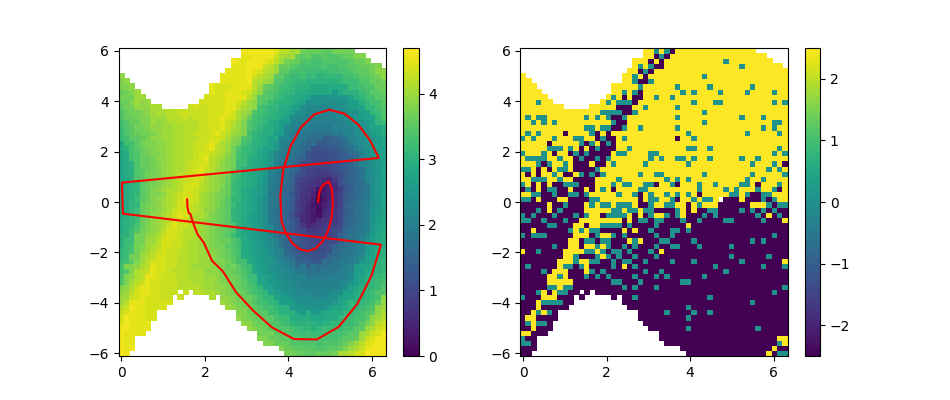

interactive(children=(IntSlider(value=1001, description='N', max=10001, min=1, step=100), Button(description='…

In [5]:
#this does forward search
tree = OptimalControlTreeSolver(problem,
                bounds,[50,60])
tree.maxVisitedPerCell = 5

display(Markdown("# Forward Solver"))
treedisplay = GridCostFunctionDisplay(tree,tree.costToCome(),tree.reversePolicy(),policyDims=1,figsize=(9.5,4))
treedisplay.show()

def do_fw_search(N):
    for i in range(N):
        tree.search_step()
    treedisplay.refresh(tree.costToCome(),tree.reversePolicy())

    path = tree.result_path()
    if tree.goal is not None:
        assert len(path) > 0
    if len(path) > 0:
        if len(path[0].state)==0:
            path = path[1:]
        if path[-1].state == None:
            path = path[:-1]
        xs = np.array([n.state for n in path])
        treedisplay.plotTrajectory(xs,color='r',zorder=3)

interact_manual(do_fw_search,N=widgets.IntSlider(min=1, max=10001, step=100, value=1001));


Model Predictive Control
------------------------

The method of model predictive control (MPC) is a process for building a
closed-loop controller when given a method that computes open-loop
trajectories. Generally speaking, it simply replans a new trajectory
starting from the sensed state at each step. It executes some small
portion of that trajectory, senses the new state, and then replans
again. By repeating this process, MPC is able to cope with unexpected
disturbances by dynamically calculating paths to return to desirable
states.

Let us define this process more specifically. Suppose the control loop
operates at rate $\Delta t$ and we have picked a time horizon $T$ for optimization,
where usually $T=N\Delta t$ for an integer $N$. MPC performs the following steps:

1.  Sense the current state $x_c$.

2.  Compute a finite-horizon optimal trajectory $x,u$ with initial state
    $x(0) = x_c$. 

3.  Execute the control $u(t)$ for $t \in [0,\Delta t)$

4.  Repeat from step 1.


TODO: illustration (Figure 8)

Overall, as employed in practice MPC is a moderately complex procedure, and from a theoretical perspective it is difficult to analyze and prove stability / convergence properties. However, with careful tuning, MPC
can be an extremely high performing and practical nonlinear optimal control
technique. There are several design decisions of note when implementing such a MPC controller:

* The time step $\Delta t$ must be long enough to allow the computation in step 2 to find
  an optimal trajectory.
* The time horizon $T$ used in step 2 is an important variable, because it should be
  long enough for MPC to benefit from predictive lookahead, but not too long such that computation time
  exceeds $\Delta t$.
* When casting the problem as a finite-horizon optimal control problem, the terminal cost should
  approximate an infinite-horizon problem's value function to some extent, or else the closed-loop
  behavior of the system may not converge properly.
* The optimization method used ought to be extremely reliable, or else the system may need
  to resort to fall-back methods (described below) that would cause performance to degrade.
* The system moves during step 2, so that by the time the control $u(0)$ is computed, the system has moved from $x_c$, so it is no longer optimal for the actual state.  Achieving better performance requires considering real-time implementations (discussed below).
* Model mismatch between the true system's dynamics and the model used in the optimizer will, in general, degrade MPC performance.

We will discuss some of these issues below.


### Initializing and running the optimizer

The optimizer used in step 2 forms the core of the procedure, and variations in its implementation drastically affect the closed-loop performance.

**Optimizer failures.** To achieve good MPC performance the optimizer should succeed regularly, but optimizer failures can be tolerated to some extent.  A straightforward fallback strategy is to maintain the previously computed trajectory, and if the optimizer fails, just continue to execute the control along the prior trajectory.  The pseudocode is as follows.

1. Maintain state / control trajectory $\tilde{x}, \tilde{u}$.

2. Sense the current state $x_c$

3. Compute a finite-horizon optimal trajectory $x,u$ with initial state
    $x(0) = x_c$. 
    
4. If optimization succeeds, set $\tilde{x}\gets x$, $\tilde{u}\gets u$. If optimization fails, time-shift $\tilde{x}(t) \gets \tilde{x}(t+\Delta t)$, $\tilde{u}(t) \gets \tilde{u}(t+\Delta t)$.  Execute the control $\tilde{u}(t)$ for $t \in [0,\Delta t)$.

5. Repeat from step 1.

Some minor details include what to do if the optimizer fails on the first iteration, and how to set $\tilde{u}$ if a series of failures occurs that shifts it beyond the end of the computed horizon.  By default we can execute the zero control until a success occurs, and we can extend the final control to an infinite horizon $\tilde{u}(t)\gets \tilde{u}(T)$ for all $t > T$.

**Optimizer initialization.**  For nonlinear optimal control problems, since local optimization is often used, the success and computation speed of MPC often depends on the availability of a good initial trajectory.  Otherwise, optimization can be extremely slow or the system can get stuck at a local optimum.  Unfortunately, there is often a design tradeoff between speed and robustness.

To minimize computation time, we can make use of the principle that the optimal trajectory for the previous iteration should be close to optimal for the current iteration. This requires us to make a change to step 3 above such that the optimizer's initial guess is set to the previously optimized trajectory, time-shifted to the current timestep:

3. Compute a finite-horizon optimal trajectory $x,u$ with initial state
    $x(0) = x_c$ and starting from initial guess $x_0(t) = \tilde{x}(\min(t + \Delta t,T))$, $u_0(t) = \tilde{u}(\min(t + \Delta t,T))$.


TODO: illustration (Figure 9)

This can make optimization very fast compared to, say, optimizing from all zeros.  A potential drawback of this method is that it can get stuck in local minima and fail to make progress. Another approach is to add "diversity" into the initialization procedure, e.g., via random restarts, so that there is a better chance of escaping local minima.  Step 3 then becomes:

3. Compute a finite-horizon optimal trajectory $x,u$ with initial state
    $x(0) = x_c$ and starting from initial guess $x_0(t) = \tilde{x}(\min(t + \Delta t,T))$, $u_0(t) = \tilde{u}(\min(t + \Delta t,T))$.
    
    - Compute another finite-horizon optimal trajectory $x^\prime,u^\prime$ with initial state
    $x(0) = x_c$ and starting from a "diverse" initial guess (e.g., a random one).
    - If $x^\prime,u^\prime$ achieves a lower cost than $x,u$, then set $x\gets x^\prime$, $u\gets u^\prime$.

This can be repeated for several diverse guesses, at the expense of additional computation.  The ultimate impact of these optimizations can be minimized by optimizing in parallel on multi-core CPUs.

### Convergence and terminal conditions

Suppose that our original optimal control problem is an infinite horizon one, with objective $J_\infty(x,u) = \int_0^\infty L(x(t),u(t)) dt$.  MPC converts it to a finite horizon problem, $J_T(x,u) = \int_0^T L(x(t),u(t)) dt + \Phi(x(T))$ where we have a choice of terminal cost $\Phi$. We should ask the questions, if the original infinite horizon problem has a stable point $x_0$, will it also be a stable point for MPC?  Will MPC converge to $x_0$ from some starting state $x_c$?  To make the following analysis hold, we assume that MPC indeed computes the finite-horizon optimal trajectory perfectly and that the true dynamics matches the model used by the optimizer.

In general this is a difficult question to answer, but we can state a few things. Let's assume that $L(x,u)\geq 0$ for all $x,u$, and that $L(x_0,u)=0$ for some $u$ satisfying $f(x_0,u)=0$ (indicating that indeed $x_0$ is a stationary point at which cost no longer accumulates).  Then:
- if $\Phi(x)\geq 0$ and $\Phi(x_0)=0$, then $x_0$ is a stable point for MPC.
- if $\Phi(x)$ is a [value function](#Derivation) $V(x)$ for the $J_\infty$ problem, then MPC will converge to $x_0$ from any starting state $x_c$.
- if $\Phi(x)$ is large for any $x \neq x_0$, then MPC will converge to $x_0$ from any starting state $x_c$ that can reach $x_0$ within horizon $T$.

Hence, most strategies for encouraging or ensuring stability are based on the second and third statements to modify the terminal conditions of the optimizer.  If we define an approximation of the infinite-horizon value function, $\Phi(x) \approx V(x)$, then MPC will generally converge quite well across the domain.  Furthermore, if we constrain the terminal state of the MPC optimization problem to be $x(T)=x_0$, then we can ensure convergence as well. The terminal constraint approach can be somewhat relaxed to constrain $x(T)$ to lie within a domain in which MPC is known to stabilize the system, or some alternative stabilizing controller is known to exist.

### Real-time considerations

Because the system timestep $\Delta t$ must be large enough to perform the optimization, the system state can change significantly between the start and the end of computation, and so the control computed by naïve MPC can be inappropriate to use at the new current state $x_c$.  Generally, the larger the timestep, the worse the degradation in performance due to real-time considerations.

**Concurrent execution and optimization.** Instead of interpreting the optimization and execution steps in the pseudocode as sequential, they should be viewed as running concurrently in time.  The execution thread continually reads from $\tilde{x}$ and $\tilde{u}$ and sends the controls to the actuators in real-time. When the MPC thread finishes computing and we say "execute the control", this really means that $\tilde{x}$ and $\tilde{u}$ are updated (atomically) so that the execution thread now reads from the new trajectories.

**Any-time feasible optimization.** When choosing optimization algorithms, *any-time, feasible* methods are preferable. Rather than waiting until the optimizer converges to some numerical tolerance, we wish to halt optimization and take the best answer after $\Delta t$ time has elapsed. A feasible method maintains iterates that are feasible so that the partially-optimized trajectory does not violate constraints regardless of when the optimizer is halted.

Note that as long as the optimization problem does not change too much from step to step, it can be effective to do less optimization work per time step but run optimization more frequently (i.e., shorten the time step).  Essentially, the cost of running an optimizer to convergence is amortized over several time steps, although with slightly different initial conditions. In the extreme, the optimizer can be configured to perform only a single iteration of an inner optimization, a technique called real-time iteration (RTI).

**Next state prediction.** Approximately $\Delta t$ time will pass between the start of optimization and the execution update. During this time, the execution thread will have executed the control $\tilde{u}(t)$ from $t=0$ to $\Delta t$, and the optimizer will have no control over the trajectory being executed.

If we call the range $t\in[0,\Delta t]$ the "immutable region", then the best we can do is control the trajectory after the immutable region passes.  Hence, one approach can be to predict the state at which we will arrive once we finish optimization (e.g., simulating the dynamics with control $\tilde{u}$ up to time $\Delta t$.  Letting $\hat{x}_p$ be the predicted state after the immutable region, we can then optimize starting from $\hat{x}_p$ rather than $x_c$. This typically leads to significantly improved performance for large time steps.

TODO: illustration (Figure 10)

**Gain scheduling.** Gain scheduling is another approach to handling inaccurate predictions. In this approach, the optimizer does not simply compute a reference trajectory $x^{ref},u^{ref}$ but also computes a sequence of gain matrices $K(t)$ such that the control $u(t) = K(t)(x(t)-x^{ref}(t)) +u^{ref}(t)$ uses feedback on the reference tracking error $x(t)-x^{ref}(t)$ to determine the next control.  Methods like DDP and iLQR compute these matrices automatically during their execution, and they provide the optimal control assuming a linearization of the dynamics and a second-order Taylor expansion of the costs about the reference trajectory.  So, rather than having the execution thread execute an open-loop trajectory over the duration $[0,\Delta t]$, it can execute the gain-scheduled policy in closed-loop during the next optimization iteration.



Summary
-------

Key takeaways:

-   Optimal control functions are specified by a dynamics function, a
    cost functional, and optional constraints. By changing the cost
    functional, different performance objectives can be specified.

-   Analytical optimal control techniques can be challenging to apply to
    a given problem, but for some problems can yield computationally
    efficient solutions by greatly reducing the search space.

-   Numerical optimal control techniques are more general, but require
    more computation.

-   In trajectory optimization, time is discretized to produce a
    finite-dimensional optimization problem. There is a tradeoff between
    optimality and speed in the choice of computational grid resolution,
    and are also susceptible to local minima.

-   In Hamilton-Jacobi-Bellman (HJB) techniques, both time and space are
    discretized. There are no local minima, but the technique suffers
    from the curse of dimensionality.

-   Model predictive control (MPC) turns open-loop trajectory
    optimization into a closed-loop controller by means of repeated
    replanning.

The [following table](#tab:OptControlSummary) lists an overview of the approaches
covered in this chapter.

********************************************************************

<div class="figcaption"><a name="tab:OptControlSummary">Summary of optimal control approaches</a></div>

| **Approach**     | **Type**   | **Characteristics** |
:------------------:|:------------:|:-----------------------------------------------------------------------:
| LQR              |Analytical  |Applies to LTI systems with quadratic costs |
| PMP              |Analytical  |Defines necessary conditions for optimality |
| Trajectory opt.  |Numerical   |Optimize a time-discretized control or trajectory space. Local minima |
| HJB              |Numerical   |Discretize and solve over state space |
| MPC              |Numerical   |Closed-loop control by repeated optimization |

********************************************************************


Exercises
---------

1.  Consider devising an optimal control formulation that describes how
    your arm should reach for a cup. What is the state $x$? The control
    $u$? The dynamics $f(x,u)$? The objective functional? Is an
    infinite-horizon or finite-horizon more appropriate for this
    problem? Do the same for the task of balancing on one foot.

2.  Recall the point mass double-integrator system:
    $$\dot{x} \equiv \begin{bmatrix}{\dot{p}}\\{\dot{v}}\end{bmatrix} = f(x,u) = \begin{bmatrix}{v}\\{u/M}\end{bmatrix}.$$
    Express this as an LTI system, and solve for the LQR gain matrix $K$
    with the cost terms $Q=\begin{bmatrix}{10}&{0}\\{0}&{1}\end{bmatrix}$ and $R=5$.

3. Let $V^*(x)$ denote the infinite-horizon value function (i.e., the cost incurred by the optimal infinite-horizon control starting at $x$).  Now define a finite-horizon optimal control problem with horizon $T$, the same incremental cost $L$, and terminal cost $\Phi(x) = V^*(x)$. Prove that the solution to this finite-horizon optimal control problem is identical to the infinite horizon optimal control problem for all $x$.

4. Let $V^*_T(x)$ denote the $T$-horizon value function for a terminal cost function $\Phi$.  Suppose that $0 \leq T_1 < T_2$. Is it always true that $V^*_{T2}(x) \geq V^*_{T1}(x)$?  If so, give a proof. If not, define a condition on $\Phi$ that would make this condition true.

5.  TBD\...
